In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env JAX_ENABLE_X64=True

from datasets import PointDataset
from models import MLPCNF

env: CUDA_VISIBLE_DEVICES=0
env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: JAX_ENABLE_X64=True


In [ ]:
dataset = PointDataset(dim=3)
model = MLPCNF(dim=128, depth=4)
params, losses = model.fit(dataset, batch_size=1024, epochs=100, learning_rate=3e-4)

  0%|          | 0/100 [00:00<?, ?it/s]

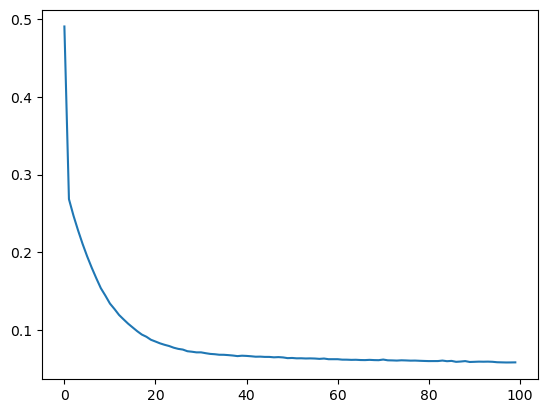

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses.mean(axis=-1))
plt.fill_between(range(len(losses)), losses.min(axis=-1), losses.max(axis=-1), alpha=0.5)

In [ ]:
from utils import corner_plot
corner_plot(dataset, model, examples=10, samples=32*1024, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: tuple index out of range